<a href="https://colab.research.google.com/github/JGuanzon/cat-preparation/blob/main/prepare_cat_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat State Preparation Protocol Simulation

We simulate the quantum optics protocols which can deterministically generate squeezed cat states, as described in our PRL paper

> Winnel, M.S., Guanzon, J.J., Singh, D. and Ralph, T.C., "Deterministic preparation of optical squeezed cat and Gottesman-Kitaev-Preskill states," [Physical Review Letters (accepted 2024)](https://journals.aps.org/prl/accepted/22074YbcY6b14b8d736f6aa1e154e89a40aa5504a).

These simulations use the strawberryfields quantum optics library. This notebook is best run on google colab.

## Set-up notebook

In [1]:
#@markdown Import and install essential libraries.
import numpy as np

import scipy.special as ssp
from scipy.signal import argrelextrema

import matplotlib as mpl
import matplotlib.pyplot as plt

import time

!pip install -q strawberryfields
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import operation

import tensorflow as tf

In [2]:
#@markdown Wigner plotting function using strawberryfields states.

sf.hbar = 0.5 #@param {type:"number"}
def plot_wigner(state, ax, x_max=5, mode=0, findmarg=False, findqmax=False):
  '''
  Plot wigner function, with q and p marginals. Requires strawberryfields library.

  Parameters:
    state (strawberryfields state): the input state, if numpy array
                    (i.e. density matrix fock space), automatically converts it.
    ax (axes): matplotlib axes to plot on.
    x_max (float): the maximum value in p and q quadratures.
    mode (int): which mode of the state to look at.
    findmarg (bool): finds and plots the marginals.
    findqmax (bool): finds the q marginal maximum peaks (need findmarg = True)
  '''
  # Convert density matrices (2d numpy arrays) to stawberryfield states
  if isinstance(state, np.ndarray):
    eng = sf.Engine("fock", backend_options={"cutoff_dim": 20})
    init = sf.Program(1)
    with init.context as q:
      sf.ops.DensityMatrix(state) | q[0] # Input Fock state
    result = eng.run(init)
    state = result.state

  # Create Wigner
  X = np.linspace(-x_max, x_max, 201)
  W = state.wigner(mode=mode, xvec=X, pvec=X)

  # Colour rescaling
  scalec = np.max(np.abs(W.real))
  cnrm = mpl.colors.Normalize(-scalec, scalec)

  # 2D Contour Plot
  ax.contourf(X, X, W, 60, cmap=mpl.cm.RdBu, norm=cnrm)
  ax.set_xlabel('q')
  ax.set_ylabel('p')
  ax.set_xlim([-x_max, x_max])
  ax.set_ylim([-x_max, x_max])
  ax.set_aspect("equal")

  # 1D Marginal Plot
  if findmarg:
    q_marg = state.x_quad_values(mode=mode, xvec=X, pvec=X)
    p_marg = state.p_quad_values(mode=mode, xvec=X, pvec=X)
    ax.plot(X, q_marg/np.max(q_marg)-x_max+0.02, color='steelblue')
    ax.plot(p_marg/np.max(p_marg)-x_max+0.02, X, color='steelblue')
    if findqmax:
      q_marg_max = X[argrelextrema(q_marg, np.greater, order=12)]
      for q_max in q_marg_max:
        ax.plot([q_max,q_max],[-x_max, x_max], '--', color='black')
      return q_marg_max

  return None

In [3]:
#@markdown Squeezing transformation functions.

def db2del(db):
  return np.sqrt(10**(-db/10.0))

def db2r(db):
  return -np.log(db2del(db))

## Protocol Simulation

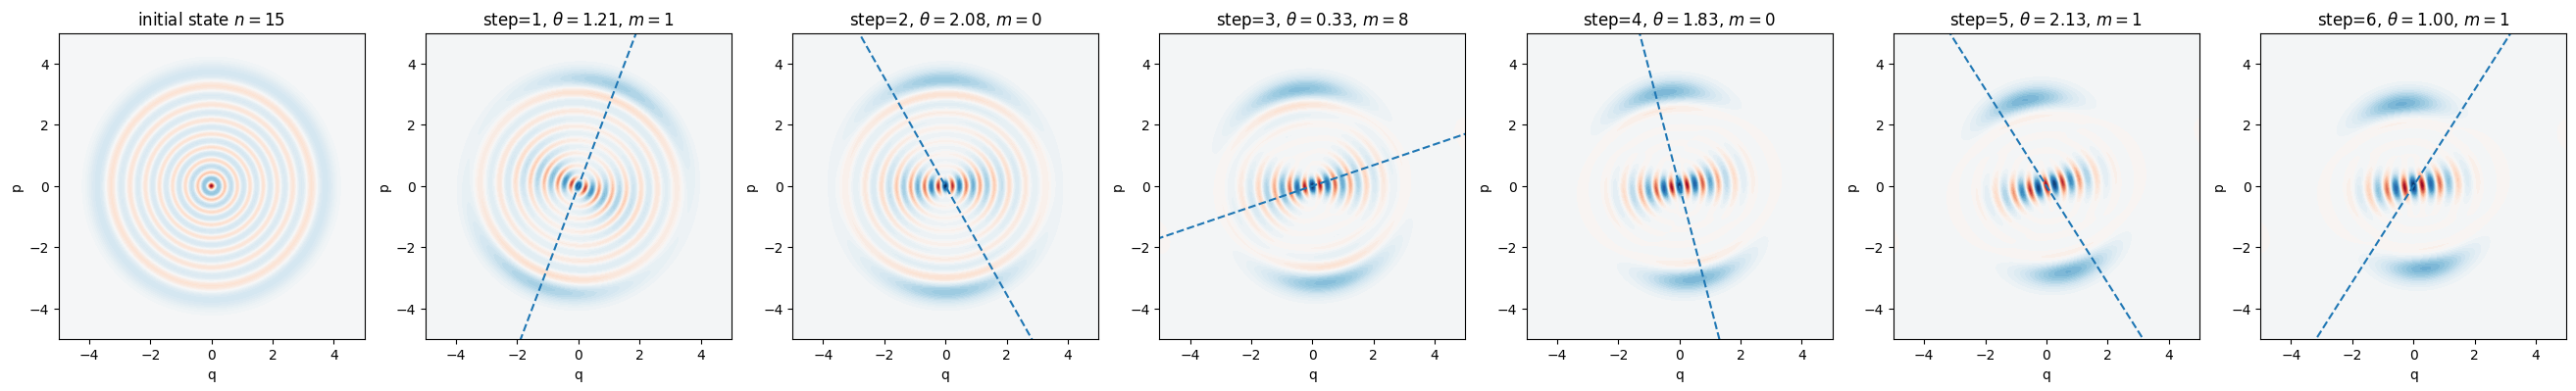

In [4]:
#@markdown Choose protocol parameters.

#@markdown Scheme as per Fig 1 in paper:
scheme = 'I' #@param ["'I'", "'II'"] {allow-input: true, type:"raw"}
#@markdown Number of repeats $k$:
k = 6 #@param {type:"integer"}
#@markdown Total transmissivity in $\eta\in[0,1]$:
etak = 1/2 #@param {type:"raw"}
eta = (etak)**(1/k) #transmissivity per beam-splitter
#@markdown Squeezing amount before detectors in dB:
r_dB = 6 #@param {type:"number"}
r = db2r(r_dB) #convert squeezing to r
#@markdown Squeezing angles $\phi$ (if manual input, number of elements needs to be $k$):
phi = 'random' # @param ["'random'", "'equal'", "2*np.pi*np.array([0.0,0.25,0.5,0.75,1.0,0.5])"] {allow-input: true, type:"raw"}
if type(phi) is str and phi == 'random':
  phi = [2*np.pi*np.random.rand() for i in range(k)]
elif type(phi) is str and phi == 'equal':
  phi = [2*np.pi*i/k for i in range(k)]
#@markdown Measurements at detectors $m$ (if manual input, number of elements needs to be $k$):
m = 'random' # @param ["'random'", "np.array([1,0,2,0,1,2])"] {allow-input: true, type:"raw"}
#@markdown Input Fock state $n$:
n = 15 #@param {type:"integer"}
#@markdown Max Fock number to simulate (ideally > $n$):
cutoff = 30 #@param {type:"integer"}

# Initialise simulation engine
eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff})

# Prepare initial Fock state
init = sf.Program(2)
with init.context as q:
  sf.ops.Fock(n) | q[0] # Input Fock state
result = eng.run(init, modes=[0])
intstate = result.state

# Perform k steps
states = []
detections = []
for i in range(k):
  step = sf.Program(2)
  with step.context as q:
    sf.ops.Vacuum() | q[1] # Vacuum state

    # Squeezing and beam-splitter
    if scheme == 'I':
      sf.ops.BSgate(np.arccos(np.sqrt(eta)),0) | (q[0],q[1])
      sf.ops.Sgate(r,phi[i]) | q[1]
    else:
      sf.ops.Sgate(r,phi[i]) | q[1]
      sf.ops.BSgate(np.arccos(np.sqrt(eta)),0) | (q[0],q[1])

    # Detection
    if type(m) is str and m == 'random':
      sf.ops.MeasureFock() | q[1]
    else:
      sf.ops.MeasureFock(select=int(m[i])) | q[1]
  result = eng.run(step, modes=[0])
  states.append(result.state)
  detections.append(result.samples[0][0])

# Plot results
fig = plt.figure(figsize=(5*k+3, 5)) # output figure
x_max = 5 # range of plot
ax = fig.add_subplot(1,k+1,1)
plot_wigner(intstate, ax, x_max)
ax.set_title("initial state $n=${}".format(n))
for i in range(k):
  ax = fig.add_subplot(1,k+1,i+2)
  plot_wigner(states[i], ax, x_max)
  ax.set_title("step={}, $\\theta=${:.2f}, $m=${}".format(i+1,phi[i]/2,detections[i]))
  ax.plot(2*x_max*np.cos(phi[i]/2)*np.array([-1,1]), 2*x_max*np.sin(phi[i]/2)*np.array([-1,1]), '--')